<a href="https://colab.research.google.com/github/sizhky/rcnn/blob/master/rcnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
%load_ext autoreload
%autoreload 2

In [2]:
project_url = 'https://github.com/sizhky/rcnn/'
import os
if not os.path.exists('rcnn'):
  !git clone {project_url}
  !pip install -q --upgrade imgaug
  !pip install -q selectivesearch
  !pip install -q --upgrade torch_snippets
  !wget http://host.robots.ox.ac.uk/pascal/VOC/voc2007/VOCtrainval_06-Nov-2007.tar
  !tar -xf VOCtrainval_06-Nov-2007.tar
  # !wget http://host.robots.ox.ac.uk/pascal/VOC/voc2007/VOCtest_06-Nov-2007.tar
  # !wget http://host.robots.ox.ac.uk/pascal/VOC/voc2012/VOCtrainval_11-May-2012.tar
%cd rcnn

Cloning into 'rcnn'...
remote: Enumerating objects: 45, done.
remote: Counting objects: 100% (45/45), done.
remote: Compressing objects: 100% (44/44), done.
remote: Total 45 (delta 12), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (45/45), done.
     |████████████████████████████████| 952kB 2.8MB/s 
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.4.0 which is incompatible.
     |████████████████████████████████| 61kB 2.6MB/s 
     |████████████████████████████████| 102kB 2.3MB/s 
--2020-05-18 14:07:40--  http://host.robots.ox.ac.uk/pascal/VOC/voc2007/VOCtrainval_06-Nov-2007.tar
Resolving host.robots.ox.ac.uk (host.robots.ox.ac.uk)... 129.67.94.152
Connecting to host.robots.ox.ac.uk (host.robots.ox.ac.uk)|129.67.94.152|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 460032000 (439M) [application/x-tar]
Saving to: ‘VOCtrainval_06-Nov-2007.tar’

VOCtrainval_06-Nov- 100%[===================>] 438.72M  4.19MB/

In [3]:
from torch_snippets import Timer, cv2, pd, choose, inspect, show
import imgaug; print(imgaug.__version__)
from load_data import *

0.4.0


In [6]:
_2007_root = Path("../VOCdevkit/VOC2007")
train_items = get_items(_2007_root, 'train')
val_items   = get_items(_2007_root, 'val')
logger.info(f'\n{len(train_items)} training images\n{len(val_items)} validation images')
train_ds = VOCDataset(train_items, tfms=None)
val_ds = VOCDataset(train_items, tfms=None)

2020-05-18 14:10:09.403 | INFO     | __main__:<module>:4 - 
2501 training images
2510 validation images


In [7]:
# vgg backbone
from torchvision import transforms, models, datasets
vgg_backbone = models.vgg16(pretrained=True)
vgg_backbone.classifier = nn.Sequential()
for param in vgg_backbone.parameters():
    param.requires_grad = False
vgg_backbone.eval().cuda()
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])
def preprocess_input(img):
    img = torch.tensor(img).permute(2,0,1)
    img = normalize(img)
    return img.cuda().float()


Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/checkpoints/vgg16-397923af.pth


In [0]:
import selectivesearch
def extract_candidates(img):
    img_lbl, regions = selectivesearch.selective_search(img, scale=100, min_size=100)
    img_area = np.prod(img.shape[:2])
    candidates = []
    for r in regions:
        if r['rect'] in candidates: continue
        if r['size'] < (0.05*img_area): continue
        if r['size'] > (1*img_area): continue
        x, y, w, h = r['rect']
        candidates.append(list(r['rect']))
    return candidates
def extract_iou(candidate, current_y, img_shape):
    'iou between bbs: candidate and current_y'
    boxA = deepcopy(candidate)
    boxB = deepcopy(current_y)
    boxA[2] += boxA[0]
    boxA[3] += boxA[1]
    iou_img1 = np.zeros(img_shape)
    iou_img1[boxA[1]:boxA[3],boxA[0]:boxA[2]]=1
    iou_img2 = np.zeros(img_shape)
    iou_img2[int(boxB[1]):int(boxB[3]),int(boxB[0]):int(boxB[2])]=1
    iou = np.sum(iou_img1*iou_img2)/(np.sum(iou_img1)+np.sum(iou_img2)-np.sum(iou_img1*iou_img2))
    return iou

In [10]:
%%time
from copy import deepcopy
CROPS, _X_, _Y_, CLSS, DELTAS = [], [], [], [], []

N = 1000 # len(train_ds)
timer = Timer(N)
for ix, (im, bbs, labels, _) in enumerate(train_ds):
    timer(ix, info=f'{len(_X_) images loaded}')
    if len(bbs) > 1: continue
    x,y,X,Y = bbs[0]
    w, h = im.size
    x,y,X,Y = x/w,y/h,X/w,Y/h
    label = (labels[0])
    _Y_ = [x,y,X-x,Y-y,label]
    im = cv2.resize(np.array(im), (224,224))
    candidates = extract_candidates(im)
    if ix >= N: break
    for jx, candidate in enumerate(candidates):
        _bb_ = [int(i*224) for i in [x,y,X,Y]]
        iou = extract_iou(candidate, _bb_, (224, 224))
        candidate_region_coordinates = c_x1, c_y1, c_w, c_h = np.array(candidate)/224
        delta = c_x1-x, c_y1-y, c_w-(X-x), c_h-(Y-y)
        DELTAS.append(delta)
        if iou>0.3 : CLSS.append(label)
        else       : CLSS.append('background')
        c_x,c_y,c_w,c_h = candidate
        l,t,r,b = c_x,c_y,c_x+c_w,c_y+c_h
        crop = im[t:b,l:r]
        crop = cv2.resize(crop, (224,224))/255.
        # CROPS.append(crop)
        with torch.no_grad():
            vgg_pred = vgg_backbone(preprocess_input(crop)[None])
        _X_.append(vgg_pred.view(1,512,7,7).cpu())

1002/1000 (250.61s - -0.25s remaining)CPU times: user 3min 57s, sys: 14.1 s, total: 4min 11s
Wall time: 4min 10s


In [34]:
len(_X_)

14093

In [0]:
targets = pd.DataFrame(CLSS, columns=['label'])
label2target = {l:t for t,l in enumerate(targets['label'].unique())}
target2label = {t:l for l,t in label2target.items()}
targets = [label2target[t] for t in targets['label']]
clss = torch.tensor(targets).long()
background_class = label2target['background']

x = torch.cat(_X_)
# x_max = x.max()
# x = x/x_max

deltas = torch.Tensor(DELTAS)

n_train = 9*len(x)//10

from torch.utils.data import TensorDataset, DataLoader
train_loader = DataLoader(TensorDataset(x[:n_train], clss[:n_train], deltas[:n_train]), batch_size=32)
test_loader = DataLoader(TensorDataset(x[n_train:], clss[n_train:], deltas[n_train:]), batch_size=32)

In [0]:
class RCNN(nn.Module):
  def __init__(self):
    super(RCNN, self).__init__()
    self.neck = nn.Sequential(
      # nn.Conv2d(512, 512, 3),
      # nn.ReLU(),
      # nn.MaxPool2d(2),
      nn.Flatten(),
      nn.Linear(25088, 512),
      nn.ReLU(),
      nn.Linear(512, 512),
      nn.ReLU(),
    )
    self.object_detector = nn.Sequential(
      nn.Linear(512, len(label2target))
    )
    self.bb_regressor = nn.Sequential(
      nn.Dropout(0.3),
      nn.Linear(512, 256),
      nn.ReLU(),
      nn.Linear(256, 4),
      nn.Sigmoid()
    )
  def forward(self, x):
    _neck_features = self.neck(x)
    _deltas = self.bb_regressor(_neck_features)
    _clss = self.object_detector(_neck_features)
    return _clss, _deltas

class ObjectDetectionLoss(nn.Module):
  def __init__(self, l, device):
    super(ObjectDetectionLoss, self).__init__()
    self.l = l
    self.device = device
    self.clss_loss = nn.CrossEntropyLoss()
    self.regr_loss = nn.L1Loss()
  def forward(self, preds, truths):
    _clss, _deltas = preds
    clss, deltas = truths
    # ixs = torch.nonzero(clss, as_tuple=True)[0]
    ixs, = torch.where(clss != background_class)
    _clss, _deltas = _clss, _deltas[ixs]
    clss, deltas = clss, deltas[ixs]
    detection_loss = self.clss_loss(_clss.to(self.device), clss.to(self.device))
    if len(ixs) > 0:
      regression_loss = self.regr_loss(_deltas.to(self.device), deltas.to(self.device))
      return detection_loss + self.l * regression_loss, detection_loss.item(), regression_loss.item()
    else:
      regression_loss = 0
      return detection_loss + self.l * regression_loss, detection_loss.item(), regression_loss

In [0]:
def decode(_y):
    _, preds = _y.max(-1)
    return preds.cpu()
def train_batch(ims, clss, deltas, model, optimizer, criterion):
    model.train()
    optimizer.zero_grad()
    _clss,_deltas = model(ims.to(device))
    # print(_clss.shape, _deltas.shape, clss.shape, deltas.shape)
    loss, loc_loss, regr_loss = criterion((_clss, _deltas), (clss, deltas))
    accs = clss == decode(_clss)
    loss.backward()
    optimizer.step()
    return loss, loc_loss, regr_loss, accs.cpu().numpy()
def validate_batch(ims, clss, deltas, model, criterion):
    with torch.no_grad():
        model.eval()
        _clss,_deltas = model(ims.to(device))
        loss, loc_loss, regr_loss = criterion((_clss, _deltas), (clss, deltas))
        _clss = decode(_clss)
        accs = clss == _clss
    return _clss, _deltas, loss, loc_loss, regr_loss, accs.cpu().numpy()


In [33]:
from torch_snippets import Report

device = 'cuda'
rcnn = RCNN().to(device)
criterion = ObjectDetectionLoss(l=10, device=device)
optimizer = optim.Adam(rcnn.parameters(), lr=1e-3)

n_epochs = 50
log = Report(n_epochs)

for epoch in range(n_epochs):
    if epoch==20: optimizer = optim.Adam(rcnn.parameters(), lr=1e-4)
    epoch_train_loss, epoch_test_loss = 0, 0
    _n = len(train_loader)
    for ix, (img,clss,deltas) in enumerate(train_loader):
        loss, loc_loss, regr_loss, accs = train_batch(img, clss, deltas, rcnn, 
                                                      optimizer, criterion)
        epoch_train_loss += loss.item()
        pos = (epoch + (ix+1)/_n)
        log.record(pos, trn_loss=loss.item(), trn_loc_loss=loc_loss, 
                   trn_regr_loss=regr_loss, 
                   trn_acc=accs.mean(), end='\r')

    _n = len(test_loader)
    for ix,(img,clss,deltas) in enumerate(test_loader):
        _clss, _deltas, loss, \
        loc_loss, regr_loss, accs = validate_batch(img, clss, deltas, 
                                                   rcnn, criterion)
        epoch_test_loss += loss.item()
        pos = (epoch + (ix+1)/_n)
        log.record(pos, val_loss=loss.item(), val_loc_loss=loc_loss, 
                   val_regr_loss=regr_loss, 
                   val_acc=accs.mean(), end='\r')
    epoch_test_loss /= (ix+1)
    if (epoch+1)%5==0: log.report_avgs(epoch+1)

EPOCH: 50.000	val_loss: 0.308	val_loc_loss: 0.000	val_regr_loss: 0.031	val_acc: 1.000	(162.24s - 0.00s remaining)

/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


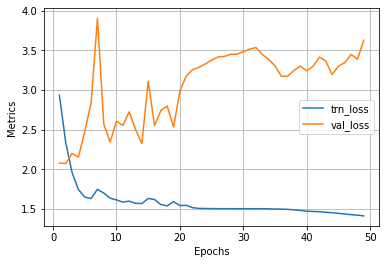

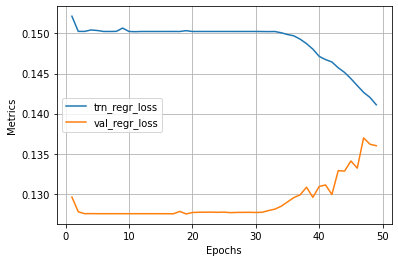

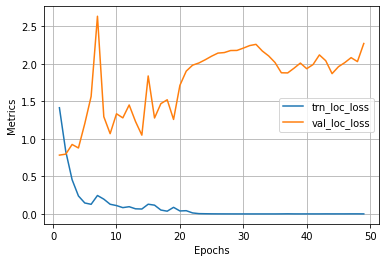

In [35]:
log.plot_epochs('trn_loss,val_loss'.split(','))
log.plot_epochs('trn_regr_loss,val_regr_loss'.split(','))
log.plot_epochs('trn_loc_loss,val_loc_loss'.split(','))

In [0]:
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.patches as mpatches
from PIL import Image
def test_predictions(filename):
    img = cv2.resize(np.array(Image.open(filename)), (224,224))
    candidates = extract_candidates(img)

    _, ax = plt.subplots(1, 2, figsize=(10,10))

    ax[0].imshow(img)
    ax[0].grid(False)
    ax[0].set_title(filename.split('/')[-1])

    pred_conf = []
    pred_class = []
    del_new = []

    for ix, candidate in enumerate(candidates):
        l, t, w, h = np.array(candidate).astype(int)
        crop = img[t:t+h,l:l+w,:3]
        crop = cv2.resize(crop,(224,224))/255.
        with torch.no_grad():
          vgg_backbone.eval()
          rcnn.eval()
          vgg_pred = vgg_backbone(preprocess_input(crop)[None])
          _clss, _deltas = rcnn(vgg_pred)
          _pred_conf, _pred_class = torch.max(_clss, -1)
        pred_conf.append(_pred_conf.cpu().item())
        pred_class.append(_pred_class.cpu().item())
        del_new.append(_deltas.cpu().detach().numpy()[0])
        
    pred_conf = np.array(pred_conf)
    pred_class = np.array(pred_class)

    pred_conf2 = pred_conf[pred_class!=0]
    pred_class2 = pred_class[pred_class!=0]
    candidates2 = np.array(candidates)[pred_class!=0]
    candidates2[:,2] += candidates2[:,0]
    candidates2[:,3] += candidates2[:,1]
    candidates2 = np.clip(candidates2, 0, 224)

    del_new2 = np.array(del_new)[pred_class!=0]*224
    bbs_pred = candidates2 - del_new2
    bbs_pred = np.clip(bbs_pred, 0, 224)
    
    bbs_pred[:,2] -= bbs_pred[:,0]
    bbs_pred[:,3] -= bbs_pred[:,1]
    
    if len(pred_conf2) == 0:
        ax[1].imshow(img)
        ax[1].set_title('No objects')
        plt.show()
        return
    final_bbs_pred = bbs_pred[np.argmax(pred_conf2)]
    x, y, w, h = final_bbs_pred
    ax[1].set_title(rev_label_map[target2label[pred_class2[np.argmax(pred_conf2)]]])
    ax[1].imshow(img)
    ax[1].grid(False)
    rect = mpatches.Rectangle((x, y), w, h, fill=False, edgecolor='red', linewidth=1)
    ax[1].add_patch(rect)
    plt.show()


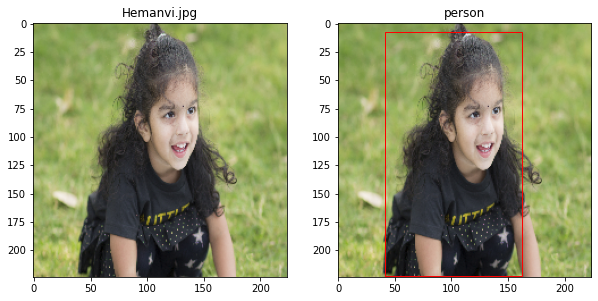

In [37]:
if not os.path.exists('Hemanvi.jpg'):
  !wget --quiet https://www.dropbox.com/s/qdoximctirsy1a9/Hemanvi.jpg
filename = 'Hemanvi.jpg'
test_predictions(filename)

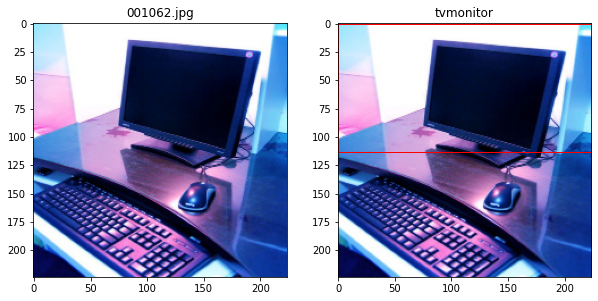

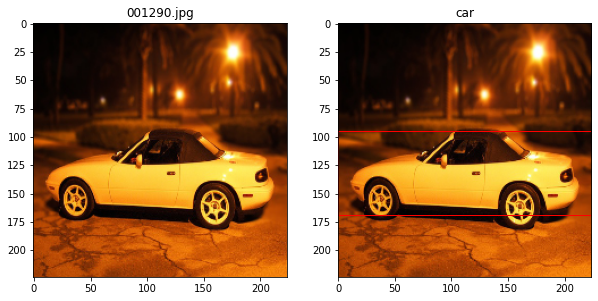

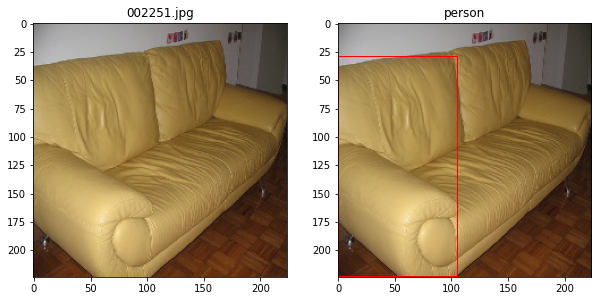

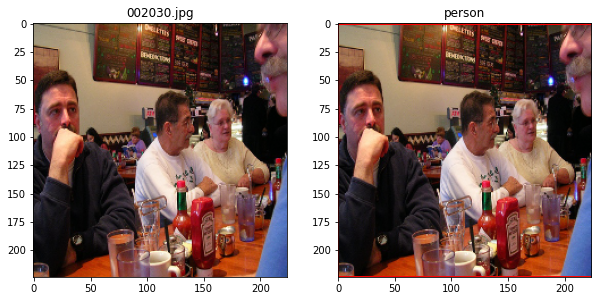

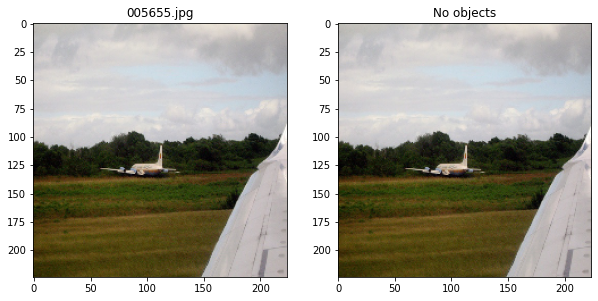

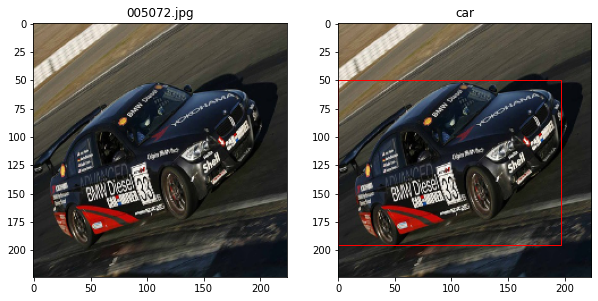

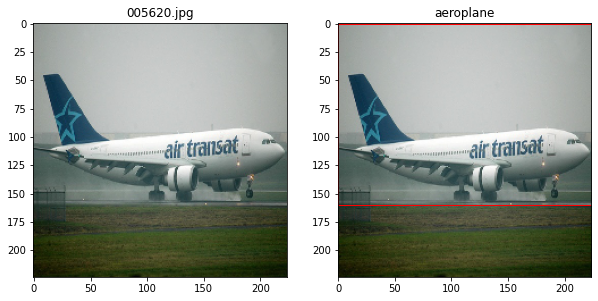

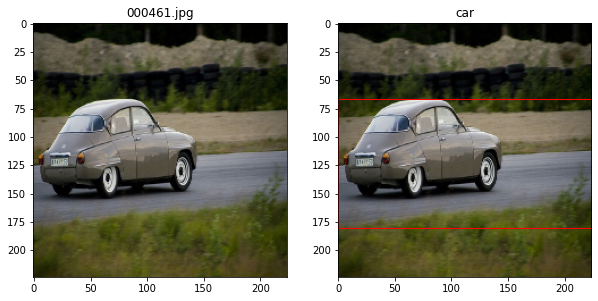

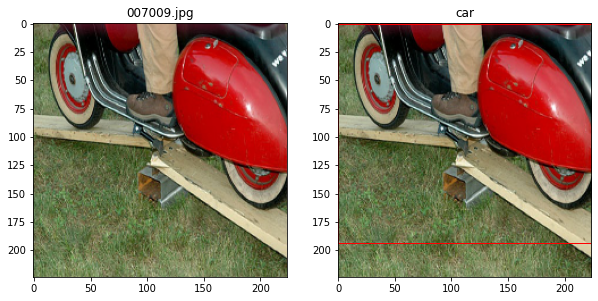

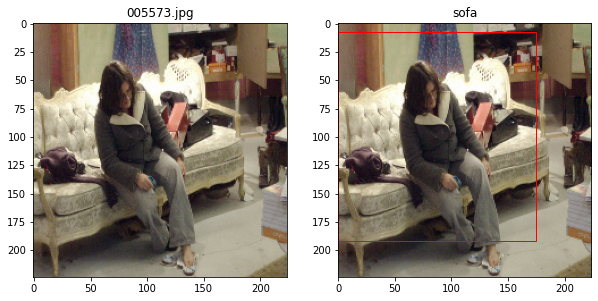

In [40]:
for _ in range(10):
    test_predictions(str(choose(val_items)[0]))